In [1]:
import plyvel
import orjson

from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import islice, chain

import numpy as np

In [37]:
def iterate_reviews(db_path, n=None):
    db = plyvel.DB(db_path)
    if n is None:
        yield from db
    else:
        yield from islice(iter(db), n)
        
    db.close()
    
def extract_review_texts(value):
    try:
        return [r['review_text']['full_html']
                for r in orjson.loads(value)['reviews']['other_user_review']]
    except:
        return []
    
def iterate_review_texts(db_path, n=None, flatten=False):
    for key, review in iterate_reviews(db_path, n=n):
        place_id = key.split(b':')[-1].decode('utf8')
        if flatten:
            yield from extract_review_texts(review)
        else:
            yield place_id, extract_review_texts(review)
            
def get_review_texts_by_id(db, place_id):
    to_close = False
    if isinstance(db, str):
        db = plyvel.DB(db)
        to_close = True
    
    key = f"reviews:all:{place_id}".encode('utf8')
    
    try:
        yield from extract_review_texts(db.get(key))
    finally:
        if to_close:
            db.close()

In [29]:
cssp = list(get_review_texts_by_id('reviews', 'ChIJX_PkfxsMzokRyg_Wdr6Nt2U'))
nockamixon = list(get_review_texts_by_id('reviews', 'ChIJmyIT0jUaxIkRhihmecUGMR0'))

In [10]:
cssp

['I had the unforgettable experience of seeing the Milky Way Galaxy and billions of stars back in August 2019. I traveled all the way from Central Jersey to Cherry Springs State Park to witness the night sky free from light pollution. My 3 day stay here was very enjoyable.<br><br>The campsites are really well kept as well as the nearby facilities. Also, cellphone reception here is surprisingly good here. I was able to stream videos here with little to no issues. I advise anyone staying here mid August to bring some long sleeves, sweaters, and long pants. This is because temperatures at night can become a bit chilly.<br><br>If you need any gas or other things such as food for your campsite,  Cherry Springs Country Store just 2 minutes down the road.<br><br>I highly recommend this park to anybody wanting to see the Milky Way.',
 'Cherry Springs State Park is an Internationally recognized "dark sky" area, popular with stargazers and amateur astronomers.  As parks go, this one is small.   

In [11]:
from spacy.lang.en.stop_words import STOP_WORDS

class Lemmatizer:
    def __init__(self, nlp_model, pos={'ADJ', 'NOUN', 'VERB', 'ADV'},
                 stop_words=STOP_WORDS):
        self.model = nlp_model
        self.pos = pos
        self.stop_words = stop_words
        
    def preprocess(self, text):
        return text.strip().lower().replace("<br>", "")
        
    def lemmatize(self, text):
        return [t.lemma_ for t in self.model(self.preprocess(text))
                if t.pos_ in self.pos and t.lower_ not in self.stop_words]

In [38]:
reviews = list(iterate_review_texts("reviews"))

In [40]:
place_id_mapping = {k: v for v, (k, _) in enumerate(reviews)}
place_ids = [k for k, _ in reviews]

reviews_content = [v for _, v in reviews]

In [16]:
import spacy

nlp = spacy.load("en_core_web_sm")
lemmatizer = Lemmatizer(nlp)

# reviews[0][0], ' '.join(lemmatizer.lemmatize(reviews[0][0]))

In [44]:
def no_op_tokenize_func(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=no_op_tokenize_func,
    preprocessor=no_op_tokenize_func,
    token_pattern=None,
    max_features=10000
)

In [42]:
def gen_concat_doc(lemmatizer, texts):
    """Concatenate all docs (review texts) for the same place into one single doc."""
    yield from chain(*[lemmatizer.lemmatize(doc) for doc in texts])

In [43]:
docs = [list(gen_concat_doc(lemmatizer, doc)) for doc in reviews_content]

In [45]:
tfidf.fit(docs)

TfidfVectorizer(max_features=10000,
                preprocessor=<function no_op_tokenize_func at 0x1301d4f70>,
                token_pattern=None,
                tokenizer=<function no_op_tokenize_func at 0x1301d4f70>)

In [46]:
len(tfidf.vocabulary_)

10000

In [22]:
def get_high_idf_tokens(tfidf, top_k=50):
    high_idf_indices = np.argsort(tfidf.idf_)[::-1]
    features = tfidf.get_feature_names()
    
    tokens = []
    for i in range(top_k):
        idx = high_idf_indices[i]
        tokens.append((features[idx], tfidf.idf_[idx]))
        
    return tokens

In [47]:
get_high_idf_tokens(tfidf)[:10]

[('medicaid', 8.740881769595523),
 ('rachet', 8.740881769595523),
 ('radiation', 8.740881769595523),
 ('radiate', 8.740881769595523),
 ('rad', 8.740881769595523),
 ('racketball', 8.740881769595523),
 ('racist', 8.740881769595523),
 ('racism', 8.740881769595523),
 ('raccoo', 8.740881769595523),
 ('radish', 8.740881769595523)]

In [48]:
transformed_place_vecs = tfidf.transform(docs)

In [49]:
transformed_place_vecs.shape

(4600, 10000)

In [60]:
pid = place_id_mapping['ChIJX_PkfxsMzokRyg_Wdr6Nt2U']
pid

2394

In [52]:
cosine_sim = transformed_place_vecs @ transformed_place_vecs.T

In [53]:
np.argsort(cosine_sim[3591, :])[::-1][:10]

array([0])

In [61]:
np.argsort(np.asarray(cosine_sim[2394, :].todense()).squeeze())[::-1][:10]

array([2394, 2385, 1800, 2734, 4477,  490, 3780, 3902,  452, 1676])

In [63]:
import pandas as pd
df = pd.read_parquet("park_info_with_review_tag.parquet")
id_to_name_mapping = {pid: name for pid, name in zip(df['id'].values, df['name'].values)}

In [69]:
def get_most_similar_parks(row_id, k=10):
    sim_scores = np.asarray(cosine_sim[row_id, :].todense()).squeeze()
    similar_row_ids = np.argsort(sim_scores)[::-1][:k]
    
    for rid, score in zip(similar_row_ids, sim_scores[similar_row_ids]):
        print(f"[{score:.3f}] {rid:5d} = {id_to_name_mapping[place_ids[rid]]}")

In [89]:
get_most_similar_parks(place_id_mapping['ChIJmyIT0jUaxIkRhihmecUGMR0'])

[1.000]  3591 = Nockamixon State Park
[0.387]  1535 = Erie Bluffs State Park
[0.365]  3607 = Harriman State Park
[0.351]  3300 = Memorial Lake State Park
[0.351]  4345 = Green Lane Park
[0.346]  1853 = Bald Eagle State Park
[0.314]  1491 = Tuscarora State Park
[0.314]  3846 = Lake Grubb Nature Park
[0.313]  2117 = Tobyhanna State Park
[0.313]  2670 = Moraine State Park


In [82]:
def print_top_tfidf_tokens(row_index, k=20):
    features = tfidf.get_feature_names()
    tf_idf_scores = np.asarray(transformed_place_vecs[row_index, :].todense()).squeeze()
    
    for idx in np.argsort(tf_idf_scores)[::-1][:k]:
        print(f"[{tf_idf_scores[idx]:.3f}] {features[idx]}")


In [94]:
print_top_tfidf_tokens(place_id_mapping['ChIJj-qY4SysyIkRPvzcS6GBbFM'], k=20)

[0.394] lake
[0.249] trail
[0.199] picnic
[0.193] boat
[0.187] walk
[0.179] couple
[0.176] dam
[0.147] kayak
[0.142] table
[0.128] place
[0.125] quick
[0.118] access
[0.117] try
[0.116] sturdy
[0.110] fishing
[0.108] shadow
[0.108] remnant
[0.107] restroom
[0.106] road
[0.102] freeze


<AxesSubplot:>

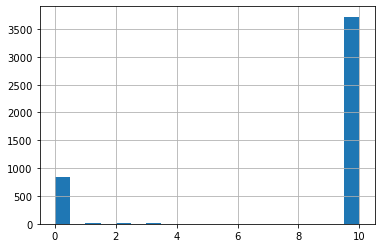

In [95]:
pd.Series([len(r) for r in reviews_content]).hist(bins=20)

In [97]:
docs[0]

['nice',
 'park',
 'walk',
 'play',
 'tennis',
 'tennis',
 'court',
 'baseball',
 'field',
 'table',
 'sit',
 'relax',
 'talk',
 'eat',
 'clearly',
 'smoke',
 'allow',
 'rule',
 'respect',
 'clean',
 'environment',
 'fresh',
 'air',
 'peaceful',
 'highly',
 'recommend',
 'friendly',
 'notice',
 'park',
 'specifically',
 'right',
 'block',
 'favourite',
 'park',
 'gteat',
 'place',
 'play',
 'game',
 'exercise',
 'good',
 'recreational',
 'area',
 'kid',
 'hang',
 'fun',
 'go',
 'community',
 'event',
 'blast',
 'town',
 'park',
 'keep',
 'good',
 'kid',
 'great',
 'park',
 'nice',
 'field',
 'negative',
 'field',
 'play',
 'small',
 'rf',
 'great',
 'place',
 'kid',
 'cool',
 'new',
 'turf',
 'feild']